In [1]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

# from prednet import PredNet
# # from data_utils import SequenceGenerator
# from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import multiprocessing
import random
import sklearn

Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras import activations
from keras.layers import Recurrent
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D
from keras.engine import InputSpec
# from keras_utils import legacy_prednet_support

class PredNet(Recurrent):
    '''PredNet architecture - Lotter 2016.
        Stacked convolutional LSTM inspired by predictive coding principles.

    # Arguments
        stack_sizes: number of channels in targets (A) and predictions (Ahat) in each layer of the architecture.
            Length is the number of layers in the architecture.
            First element is the number of channels in the input.
            Ex. (3, 16, 32) would correspond to a 3 layer architecture that takes in RGB images and has 16 and 32
                channels in the second and third layers, respectively.
        R_stack_sizes: number of channels in the representation (R) modules.
            Length must equal length of stack_sizes, but the number of channels per layer can be different.
        A_filt_sizes: filter sizes for the target (A) modules.
            Has length of 1 - len(stack_sizes).
            Ex. (3, 3) would mean that targets for layers 2 and 3 are computed by a 3x3 convolution of the errors (E)
                from the layer below (followed by max-pooling)
        Ahat_filt_sizes: filter sizes for the prediction (Ahat) modules.
            Has length equal to length of stack_sizes.
            Ex. (3, 3, 3) would mean that the predictions for each layer are computed by a 3x3 convolution of the
                representation (R) modules at each layer.
        R_filt_sizes: filter sizes for the representation (R) modules.
            Has length equal to length of stack_sizes.
            Corresponds to the filter sizes for all convolutions in the LSTM.
        pixel_max: the maximum pixel value.
            Used to clip the pixel-layer prediction.
        error_activation: activation function for the error (E) units.
        A_activation: activation function for the target (A) and prediction (A_hat) units.
        LSTM_activation: activation function for the cell and hidden states of the LSTM.
        LSTM_inner_activation: activation function for the gates in the LSTM.
        output_mode: either 'error', 'prediction', 'all' or layer specification (ex. R2, see below).
            Controls what is outputted by the PredNet.
            If 'error', the mean response of the error (E) units of each layer will be outputted.
                That is, the output shape will be (batch_size, nb_layers).
            If 'prediction', the frame prediction will be outputted.
            If 'all', the output will be the frame prediction concatenated with the mean layer errors.
                The frame prediction is flattened before concatenation.
                Nomenclature of 'all' is kept for backwards compatibility, but should not be confused with returning all of the layers of the model
            For returning the features of a particular layer, output_mode should be of the form unit_type + layer_number.
                For instance, to return the features of the LSTM "representational" units in the lowest layer, output_mode should be specificied as 'R0'.
                The possible unit types are 'R', 'Ahat', 'A', and 'E' corresponding to the 'representation', 'prediction', 'target', and 'error' units respectively.
        extrap_start_time: time step for which model will start extrapolating.
            Starting at this time step, the prediction from the previous time step will be treated as the "actual"
        data_format: 'channels_first' or 'channels_last'.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.

    # References
        - [Deep predictive coding networks for video prediction and unsupervised learning](https://arxiv.org/abs/1605.08104)
        - [Long short-term memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
        - [Convolutional LSTM network: a machine learning approach for precipitation nowcasting](http://arxiv.org/abs/1506.04214)
        - [Predictive coding in the visual cortex: a functional interpretation of some extra-classical receptive-field effects](http://www.nature.com/neuro/journal/v2/n1/pdf/nn0199_79.pdf)
    '''
#     @legacy_prednet_support
    def __init__(self, stack_sizes, R_stack_sizes,
                 A_filt_sizes, Ahat_filt_sizes, R_filt_sizes,
                 pixel_max=1., error_activation='relu', A_activation='relu',
                 LSTM_activation='tanh', LSTM_inner_activation='hard_sigmoid',
                 conv_dropout=0.8,
                 output_mode='error', extrap_start_time=None,
                 data_format=K.image_data_format(), **kwargs):
        self.stack_sizes = stack_sizes
        self.nb_layers = len(stack_sizes)
        assert len(R_stack_sizes) == self.nb_layers, 'len(R_stack_sizes) must equal len(stack_sizes)'
        self.R_stack_sizes = R_stack_sizes
        assert len(A_filt_sizes) == (self.nb_layers - 1), 'len(A_filt_sizes) must equal len(stack_sizes) - 1'
        self.A_filt_sizes = A_filt_sizes
        assert len(Ahat_filt_sizes) == self.nb_layers, 'len(Ahat_filt_sizes) must equal len(stack_sizes)'
        self.Ahat_filt_sizes = Ahat_filt_sizes
        assert len(R_filt_sizes) == (self.nb_layers), 'len(R_filt_sizes) must equal len(stack_sizes)'
        self.R_filt_sizes = R_filt_sizes

        self.pixel_max = pixel_max
        self.error_activation = activations.get(error_activation)
        self.A_activation = activations.get(A_activation)
        self.LSTM_activation = activations.get(LSTM_activation)
        self.LSTM_inner_activation = activations.get(LSTM_inner_activation)
        self.conv_dropout = conv_dropout

        default_output_modes = ['prediction', 'error', 'all']
        layer_output_modes = [layer + str(n) for n in range(self.nb_layers) for layer in ['R', 'E', 'A', 'Ahat']]
        assert output_mode in default_output_modes + layer_output_modes, 'Invalid output_mode: ' + str(output_mode)
        self.output_mode = output_mode
        if self.output_mode in layer_output_modes:
            self.output_layer_type = self.output_mode[:-1]
            self.output_layer_num = int(self.output_mode[-1])
        else:
            self.output_layer_type = None
            self.output_layer_num = None
        self.extrap_start_time = extrap_start_time

        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {channels_last, channels_first}'
        self.data_format = data_format
        self.channel_axis = -3 if data_format == 'channels_first' else -1
        self.row_axis = -2 if data_format == 'channels_first' else -3
        self.column_axis = -1 if data_format == 'channels_first' else -2
        super(PredNet, self).__init__(**kwargs)
        self.input_spec = [InputSpec(ndim=5)]

    def compute_output_shape(self, input_shape):
        if self.output_mode == 'prediction':
            out_shape = input_shape[2:]
        elif self.output_mode == 'error':
            out_shape = (self.nb_layers,)
        elif self.output_mode == 'all':
            out_shape = (np.prod(input_shape[2:]) + self.nb_layers,)
        else:
            stack_str = 'R_stack_sizes' if self.output_layer_type == 'R' else 'stack_sizes'
            stack_mult = 2 if self.output_layer_type == 'E' else 1
            out_stack_size = stack_mult * getattr(self, stack_str)[self.output_layer_num]
            out_nb_row = input_shape[self.row_axis] / 2**self.output_layer_num
            out_nb_col = input_shape[self.column_axis] / 2**self.output_layer_num
            if self.data_format == 'channels_first':
                out_shape = (out_stack_size, out_nb_row, out_nb_col)
            else:
                out_shape = (out_nb_row, out_nb_col, out_stack_size)

        if self.return_sequences:
            return (input_shape[0], input_shape[1]) + out_shape
        else:
            return (input_shape[0],) + out_shape

    def get_initial_state(self, x):
        input_shape = self.input_spec[0].shape
        init_nb_row = input_shape[self.row_axis]
        init_nb_col = input_shape[self.column_axis]

        base_initial_state = K.zeros_like(x)  # (samples, timesteps) + image_shape
        non_channel_axis = -1 if self.data_format == 'channels_first' else -2
        for _ in range(2):
            base_initial_state = K.sum(base_initial_state, axis=non_channel_axis)
        base_initial_state = K.sum(base_initial_state, axis=1)  # (samples, nb_channels)

        initial_states = []
        states_to_pass = ['r', 'c', 'e']
        nlayers_to_pass = {u: self.nb_layers for u in states_to_pass}
        if self.extrap_start_time is not None:
            states_to_pass.append('ahat')  # pass prediction in states so can use as actual for t+1 when extrapolating
            nlayers_to_pass['ahat'] = 1
        for u in states_to_pass:
            for l in range(nlayers_to_pass[u]):
                ds_factor = 2 ** l
                nb_row = init_nb_row // ds_factor
                nb_col = init_nb_col // ds_factor
                if u in ['r', 'c']:
                    stack_size = self.R_stack_sizes[l]
                elif u == 'e':
                    stack_size = 2 * self.stack_sizes[l]
                elif u == 'ahat':
                    stack_size = self.stack_sizes[l]
                output_size = stack_size * nb_row * nb_col  # flattened size

                reducer = K.zeros((input_shape[self.channel_axis], output_size)) # (nb_channels, output_size)
                initial_state = K.dot(base_initial_state, reducer) # (samples, output_size)
                if self.data_format == 'channels_first':
                    output_shp = (-1, stack_size, nb_row, nb_col)
                else:
                    output_shp = (-1, nb_row, nb_col, stack_size)
                initial_state = K.reshape(initial_state, output_shp)
                initial_states += [initial_state]

        if K._BACKEND == 'theano':
            from theano import tensor as T
            # There is a known issue in the Theano scan op when dealing with inputs whose shape is 1 along a dimension.
            # In our case, this is a problem when training on grayscale images, and the below line fixes it.
            initial_states = [T.unbroadcast(init_state, 0, 1) for init_state in initial_states]

        if self.extrap_start_time is not None:
            initial_states += [K.variable(0, int if K.backend() != 'tensorflow' else 'int32')]  # the last state will correspond to the current timestep
        return initial_states

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        self.conv_layers = {c: [] for c in ['i', 'f', 'c', 'o', 'a', 'ahat']}

        for l in range(self.nb_layers):
            for c in ['i', 'f', 'c', 'o']:
                act = self.LSTM_activation if c == 'c' else self.LSTM_inner_activation
                self.conv_layers[c].append(Conv2D(self.R_stack_sizes[l], self.R_filt_sizes[l], padding='same', activation=act, data_format=self.data_format))
#                 self.conv_layers[c].append(keras.layers.Dropout(self.conv_dropout))

            act = 'relu' if l == 0 else self.A_activation
            self.conv_layers['ahat'].append(Conv2D(self.stack_sizes[l], self.Ahat_filt_sizes[l], padding='same', activation=act, data_format=self.data_format))

            if l < self.nb_layers - 1:
                self.conv_layers['a'].append(Conv2D(self.stack_sizes[l+1], self.A_filt_sizes[l], padding='same', activation=self.A_activation, data_format=self.data_format))

        self.upsample = UpSampling2D(data_format=self.data_format)
        self.pool = MaxPooling2D(data_format=self.data_format)

        self.trainable_weights = []
        nb_row, nb_col = (input_shape[-2], input_shape[-1]) if self.data_format == 'channels_first' else (input_shape[-3], input_shape[-2])
        for c in sorted(self.conv_layers.keys()):
            for l in range(len(self.conv_layers[c])):
                ds_factor = 2 ** l
                if c == 'ahat':
                    nb_channels = self.R_stack_sizes[l]
                elif c == 'a':
                    nb_channels = 2 * self.R_stack_sizes[l]
                else:
                    nb_channels = self.stack_sizes[l] * 2 + self.R_stack_sizes[l]
                    if l < self.nb_layers - 1:
                        nb_channels += self.R_stack_sizes[l+1]
                in_shape = (input_shape[0], nb_channels, nb_row // ds_factor, nb_col // ds_factor)
                if self.data_format == 'channels_last': in_shape = (in_shape[0], in_shape[2], in_shape[3], in_shape[1])
                with K.name_scope('layer_' + c + '_' + str(l)):
                    self.conv_layers[c][l].build(in_shape)
                self.trainable_weights += self.conv_layers[c][l].trainable_weights

        self.states = [None] * self.nb_layers*3

        if self.extrap_start_time is not None:
            self.t_extrap = K.variable(self.extrap_start_time, int if K.backend() != 'tensorflow' else 'int32')
            self.states += [None] * 2  # [previous frame prediction, timestep]

    def step(self, a, states):
        r_tm1 = states[:self.nb_layers]
        c_tm1 = states[self.nb_layers:2*self.nb_layers]
        e_tm1 = states[2*self.nb_layers:3*self.nb_layers]

        if self.extrap_start_time is not None:
            t = states[-1]
            a = K.switch(t >= self.t_extrap, states[-2], a)  # if past self.extrap_start_time, the previous prediction will be treated as the actual

        c = []
        r = []
        e = []

        # Update R units starting from the top
        for l in reversed(range(self.nb_layers)):
            inputs = [r_tm1[l], e_tm1[l]]
            if l < self.nb_layers - 1:
                inputs.append(r_up)

            inputs = K.concatenate(inputs, axis=self.channel_axis)
            i = self.conv_layers['i'][l].call(inputs)
            f = self.conv_layers['f'][l].call(inputs)
            o = self.conv_layers['o'][l].call(inputs)
            _c = f * c_tm1[l] + i * self.conv_layers['c'][l].call(inputs)
            _r = o * self.LSTM_activation(_c)
            c.insert(0, _c)
            r.insert(0, _r)

            if l > 0:
                r_up = self.upsample.call(_r)

        # Update feedforward path starting from the bottom
        for l in range(self.nb_layers):
            ahat = self.conv_layers['ahat'][l].call(r[l])
            if l == 0:
                ahat = K.minimum(ahat, self.pixel_max)
                frame_prediction = ahat

            # compute errors
            e_up = self.error_activation(ahat - a)
            e_down = self.error_activation(a - ahat)

            e.append(K.concatenate((e_up, e_down), axis=self.channel_axis))

            if self.output_layer_num == l:
                if self.output_layer_type == 'A':
                    output = a
                elif self.output_layer_type == 'Ahat':
                    output = ahat
                elif self.output_layer_type == 'R':
                    output = r[l]
                elif self.output_layer_type == 'E':
                    output = e[l]

            if l < self.nb_layers - 1:
                a = self.conv_layers['a'][l].call(e[l])
                a = self.pool.call(a)  # target for next layer

        if self.output_layer_type is None:
            if self.output_mode == 'prediction':
                output = frame_prediction
            else:
                for l in range(self.nb_layers):
                    layer_error = K.mean(K.batch_flatten(e[l]), axis=-1, keepdims=True)
                    all_error = layer_error if l == 0 else K.concatenate((all_error, layer_error), axis=-1)
                if self.output_mode == 'error':
                    output = all_error
                else:
                    output = K.concatenate((K.batch_flatten(frame_prediction), all_error), axis=-1)

        states = r + c + e
        if self.extrap_start_time is not None:
            states += [frame_prediction, t + 1]
        return output, states

    def get_config(self):
        config = {'stack_sizes': self.stack_sizes,
                  'R_stack_sizes': self.R_stack_sizes,
                  'A_filt_sizes': self.A_filt_sizes,
                  'Ahat_filt_sizes': self.Ahat_filt_sizes,
                  'R_filt_sizes': self.R_filt_sizes,
                  'pixel_max': self.pixel_max,
                  'error_activation': self.error_activation.__name__,
                  'A_activation': self.A_activation.__name__,
                  'LSTM_activation': self.LSTM_activation.__name__,
                  'LSTM_inner_activation': self.LSTM_inner_activation.__name__,
                  'data_format': self.data_format,
                  'extrap_start_time': self.extrap_start_time,
                  'output_mode': self.output_mode}
        base_config = super(PredNet, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-09-04 22:21:37


In [3]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

15000


In [4]:
def check_RAD_id(RAD_id):
    mean_list = []
    for k in range(61):
        mean_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().mean())
    mean_list = np.array(mean_list)
    if mean_list.mean() < -0.5:
        return None
    for k in range(59):
        if abs(mean_list[k] + mean_list[k + 2] - 2 * mean_list[k + 1]) > 2:
            return None
    return RAD_id

In [5]:
pool = multiprocessing.Pool()
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
# map(check_RAD_id, raw_RAD_id_list[:100])
# print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = list(pool.map(check_RAD_id, raw_RAD_id_list))
RAD_id_list = [x for x in RAD_id_list if x is not None]
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-09-04 19:49:53
end time: 2018-09-04 19:50:50
00:00:56
6562


Process ForkPoolWorker-14:
Process ForkPoolWorker-23:
Process ForkPoolWorker-32:
Process ForkPoolWorker-20:
Process ForkPoolWorker-18:
Process ForkPoolWorker-28:
Process ForkPoolWorker-29:
Process ForkPoolWorker-27:
Process ForkPoolWorker-24:
Process ForkPoolWorker-7:
Process ForkPoolWorker-19:
Process ForkPoolWorker-17:
Process ForkPoolWorker-26:
Process ForkPoolWorker-31:
Process ForkPoolWorker-13:
Process ForkPoolWorker-3:
Process ForkPoolWorker-15:
Process ForkPoolWorker-12:
Process ForkPoolWorker-25:
Process ForkPoolWorker-16:
Process ForkPoolWorker-8:
Process ForkPoolWorker-22:
Process ForkPoolWorker-10:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-30:
Traceback (most recent call last):
Process ForkPoolWorker-11:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Process ForkPoolWorker-21:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-6:
Process ForkP

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._tar

KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/queues.py", li

In [5]:
step_size = 2

class trainGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
#         y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            offset = random.randint(0, 61 - self.nt * step_size)
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + offset)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#             y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 1)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-09-04 22:21:45


In [6]:
# Model parameters
image_size = 256
nt = 10 # number of timesteps used for sequences in training
image_scalar = 80
vmin = -1
vmax = 0.6 * image_scalar
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)
layer_loss_weights = np.array([1., 0., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes,
                  A_activation='elu', error_activation='elu',
                  LSTM_inner_activation='sigmoid',
                  output_mode='error', return_sequences=True, extrap_start_time=6)

inputs = Input(shape=(nt,) + input_shape)
errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
outputs = final_errors
# outputs = np.empty(shape=(nt,) + input_shape)
# for i in range(nt):
#     temp_outputs = prednet(inputs)
#     outputs[i] = temp_outputs
#     for j in range(nt - 1):
#         inputs[j] = inputs[j + 1]
#     inputs[-1] = temp_outputs

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.5))
#     w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.losses.absolute_difference(y_true, y_pred)
#     loss = tf.multiply(loss, tf.constant(1000000000.0))
    return loss

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-09-04 22:21:47


In [10]:
a = prednet.conv_layers['a'][0]

In [14]:
'conv' in prednet.conv_layers['a'][0].name

True

In [175]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 10, 256, 256, 1)   0         
_________________________________________________________________
pred_net_12 (PredNet)        (None, 10, 4)             6909818   
_________________________________________________________________
time_distributed_12 (TimeDis (None, 10, 1)             5         
_________________________________________________________________
flatten_12 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 11        
Total params: 6,909,834
Trainable params: 6,909,818
Non-trainable params: 16
_________________________________________________________________


how to use tensorboard

```bash
jupyter notebook --ip=192.168.2.101
python3 /usr/local/lib/python3.5/dist-packages/tensorboard/main.py --logdir='/home/hadoop/Documents/Neutrino/tensorboard_logs' --host=192.168.2.101 --port=8900
rm -rf /home/hadoop/Documents/Neutrino/tensorboard_logs
scp "C:/Users/Administrator/Downloads/SRAD2018_Test_1.zip" hadoop@192.168.1.115:~/Documents/Neutrino/SRAD2018/SRAD2018_test
mv -v ~/Documents/Neutrino/SRAD2018/SRAD2018_test/SRAD2018_Test_1* ~/Documents/Neutrino/SRAD2018/SRAD2018_test
lsof /dev/nvidia0
lsof -n -i4TCP:8888
kill -9 -[PID]
```

`http://222.200.177.32:8900/#scalars&run=.&_smoothingWeight=0.8`

`http://222.200.177.32:8888`

In [143]:
lr_schedule = lambda epoch: 0.001 if epoch < 20 else 0.0003    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0, write_graph=False)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

```
step_size = 1
133000
model_loss=41.5898705

step_size = 2
147775.0609 
model_loss=41.5898705
```

In [144]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = trainGenerator(list_IDs=RAD_id_list[-4:-3], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = trainGenerator(list_IDs=RAD_id_list[:12], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1, shuffle=False)
history = model.fit_generator(train_generator, steps_per_epoch=30, epochs=50, validation_data=valid_generator, validation_steps=12, use_multiprocessing=True, max_queue_size=20, callbacks=callbacks)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))

start time: 2018-09-04 21:37:05
Epoch 1/50
30/30 [==============================] - 22s 740ms/step - loss: 9.9880e-04 - val_loss: 3.2195e-04
Epoch 2/50
30/30 [==============================] - 18s 606ms/step - loss: 3.4071e-04 - val_loss: 3.0509e-04
Epoch 3/50
30/30 [==============================] - 18s 607ms/step - loss: 2.9485e-04 - val_loss: 2.8007e-04
Epoch 4/50
30/30 [==============================] - 18s 615ms/step - loss: 2.8093e-04 - val_loss: 3.0535e-04
Epoch 5/50
30/30 [==============================] - 19s 633ms/step - loss: 2.8517e-04 - val_loss: 2.6395e-04
Epoch 6/50
30/30 [==============================] - 18s 616ms/step - loss: 2.7575e-04 - val_loss: 2.7248e-04
Epoch 7/50
30/30 [==============================] - 18s 609ms/step - loss: 2.5644e-04 - val_loss: 2.7041e-04
Epoch 8/50
30/30 [==============================] - 18s 616ms/step - loss: 2.6311e-04 - val_loss: 2.7018e-04
Epoch 9/50
30/30 [==============================] - 18s 613ms/step - loss: 2.7064e-04 - val_loss

Process ForkPoolWorker-9187:
Process ForkPoolWorker-9199:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.5/multiprocessing/connect

KeyboardInterrupt: 

In [176]:
lr_schedule = lambda epoch: 0.0003 if epoch < 20 else 0.00001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
tb_callback = keras.callbacks.TensorBoard(log_dir='/home/hadoop/Documents/Neutrino/tensorboard_logs', histogram_freq=0, write_graph=False)
callbacks = [LearningRateScheduler(lr_schedule), tb_callback]

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
start_time = time.time()
train_generator = trainGenerator(list_IDs=RAD_id_list[:6000], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = trainGenerator(list_IDs=RAD_id_list[-20:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=valid_generator, validation_steps=20, callbacks=callbacks)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))

start time: 2018-09-04 22:01:27
Epoch 1/100
100/100 [==============================] - 54s 537ms/step - loss: 4.4656e-04 - val_loss: 2.5550e-04
Epoch 2/100
100/100 [==============================] - 51s 510ms/step - loss: 2.5961e-04 - val_loss: 2.2322e-04
Epoch 3/100
100/100 [==============================] - 51s 514ms/step - loss: 2.4033e-04 - val_loss: 2.2672e-04
Epoch 4/100
100/100 [==============================] - 51s 513ms/step - loss: 2.4452e-04 - val_loss: 2.4687e-04
Epoch 5/100
100/100 [==============================] - 52s 515ms/step - loss: 2.6224e-04 - val_loss: 2.2128e-04
Epoch 6/100
100/100 [==============================] - 51s 509ms/step - loss: 2.1420e-04 - val_loss: 1.9824e-04
Epoch 7/100
100/100 [==============================] - 51s 507ms/step - loss: 2.0671e-04 - val_loss: 1.9464e-04
Epoch 8/100
100/100 [==============================] - 51s 508ms/step - loss: 1.9259e-04 - val_loss: 2.1352e-04
Epoch 9/100
100/100 [==============================] - 50s 505ms/step - 

# 测试验证

## `return_sequences=True`

In [ ]:
train_model = model
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)

In [ ]:
test_inputs = Input(shape=(nt,) + input_shape)
test_outputs = test_prednet(test_inputs)

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.8))
#     w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(10000000.0))
    return loss

test_model = keras.models.Model(inputs=test_inputs, outputs=test_outputs)
test_model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

In [ ]:
class testGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 1)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 1)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#         y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

In [ ]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = testGenerator(list_IDs=RAD_id_list[:6000], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = testGenerator(list_IDs=RAD_id_list[-1:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)

In [ ]:
# train_generator.on_epoch_end()
# valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
y = test_model.predict(x)

plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
print('↓↓↓下面的是模型一整段的输出，上面的是最后一张输出↑↑↑')
for i in range(y.shape[1]):
    plt.imshow(y[0][i].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
    plt.show()

In [ ]:
# train_generator.on_epoch_end()
# valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
for i in range(30):
    y = test_model.predict(x)
    y = np.where(y<0.01, -0.01, y)
    for j in range(nt - 1):
        x[0][j] = x[0][j + 1]
    x[0][-1] = y[0][-1]
    print('%2d:' % i)
    plt.imshow(y[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
    plt.show()

# plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
# plt.show()
# print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
# plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
# plt.show()
# print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
# plt.imshow(y[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
# plt.show()
# print('↓↓↓下面的是模型一整段的输出，上面的是最后一张输出↑↑↑')
# for i in range(y.shape[1]):
#     plt.imshow(y[0][i].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
#     plt.show()

## 保存模型

In [ ]:
version = 'SRAD2018_Neutrino_PredNet_v0.3.5.1_nt10_18.09.02.23.07'
model.save('/home/hadoop/Documents/Neutrino/prednet/%s.hdf5' % version)
model.save_weights('/home/hadoop/Documents/Neutrino/prednet/%s_weights.hdf5' % version)

In [ ]:
model.load_weights()

## `return_sequences=False`

In [150]:
train_model = model
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
layer_config['return_sequences'] = False
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)

In [151]:
test_inputs = Input(shape=(nt,) + input_shape)
test_outputs = test_prednet(test_inputs)

def my_loss(y_true, y_pred):
#     w = tf.add(y_true, tf.constant(0.8))
#     w = tf.add(y_pred, w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
    loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(10000000.0))
    return loss

test_model = keras.models.Model(inputs=test_inputs, outputs=test_outputs)
test_model.compile(loss=my_loss, optimizer=keras.optimizers.Adam())
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-09-04 21:57:02


In [167]:
class testGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * step_size + 30 - (nt - 1) * step_size)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#             y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (self.nt) * 1)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
            y[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 60)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
#         y = np.zeros(self.batch_size, np.float32)
        return X, y
print(time.strftime('build time: %Y-%m-%d %H:%M:%S', time.localtime()))

build time: 2018-09-04 21:59:57


In [168]:
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
train_generator = testGenerator(list_IDs=RAD_id_list[:1], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = testGenerator(list_IDs=RAD_id_list[-4:-3], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)

start time: 2018-09-04 21:59:58


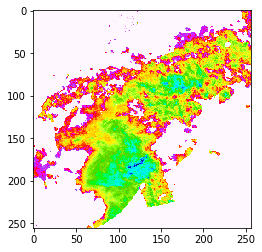

↓↓↓下面的是真实值，上面的是上一张↑↑↑


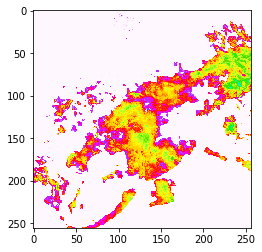

↓↓↓下面的是模型的输出，上面的是真实值↑↑↑


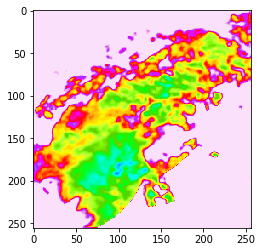

In [169]:
train_generator.on_epoch_end()
valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
y = test_model.predict(x)

plt.imshow(x[0][-1].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
print('↓↓↓下面的是真实值，上面的是上一张↑↑↑')
plt.imshow(y_[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
print('↓↓↓下面的是模型的输出，上面的是真实值↑↑↑')
plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()

 0:


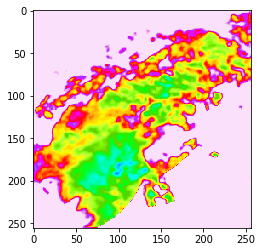

 1:


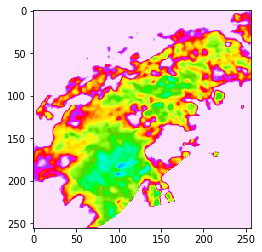

 2:


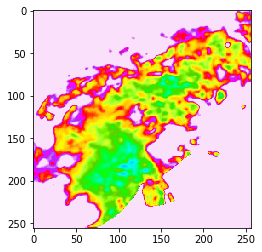

 3:


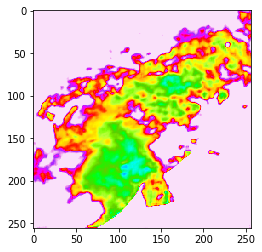

 4:


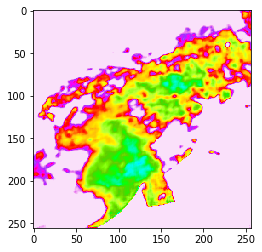

 5:


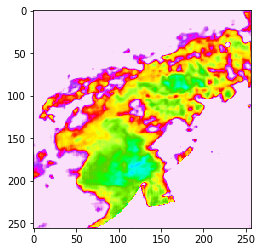

 6:


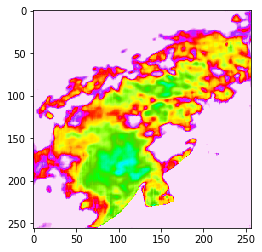

 7:


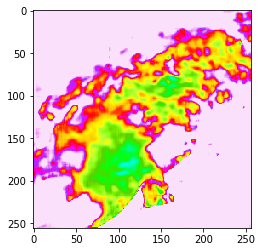

 8:


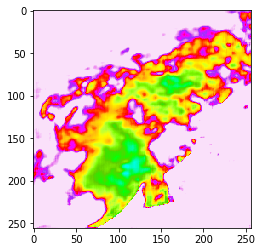

 9:


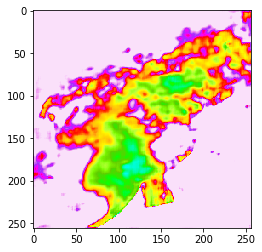

10:


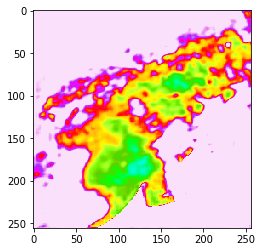

11:


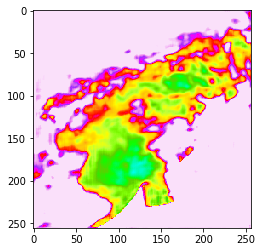

12:


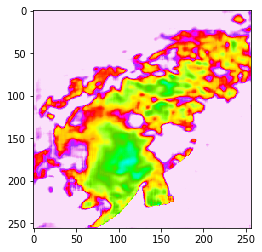

13:


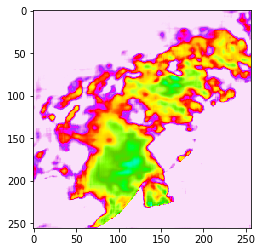

14:


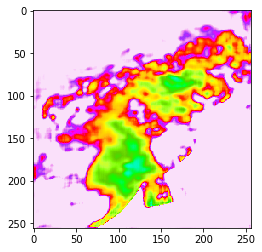

In [170]:
# train_generator.on_epoch_end()
# valid_generator.on_epoch_end()
for data in [train_generator, valid_generator][1]:
    x, y_ = data
    break
for i in range(30 // step_size):
    y = test_model.predict(x)
#     y = np.where(y<0.03, -0.01, y)
#     y = np.where(y>0.6, 0.6, y)
    for j in range(nt - 1):
        x[0][j] = x[0][j + 1]
    x[0][-1] = y[0]
    print('%2d:' % i)
    plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
    plt.show()

In [171]:
start_time = time.time()
print(time.strftime("start time: %Y-%m-%d %H:%M:%S", time.localtime()))
model_loss = []
last_frame_loss = []
for RAD_id_counter, RAD_id in enumerate(RAD_id_list[-4:-3]):
    x = np.empty((nt, image_size, image_size, 1))
    y = np.empty((1, image_size, image_size, 1))
    y_true_last = np.empty((1, image_size, image_size, 1))
    for i in range(nt):
        x[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i * step_size + 30 - (nt - 1) * step_size)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / image_scalar
    x = x.reshape((1, nt, image_size, image_size, 1))
    for i in range(30 // step_size):
        y = test_model.predict(x)
#         y = np.where(y<0.03, -1/image_scalar, y)
        for j in range(nt - 1):
            x[0][j] = x[0][j + 1]
        x[0][-1] = y[0]
    x_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 30)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
    y_true_last = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, 60)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size))
    y_pred_last = y[0].reshape((image_size, image_size)) * image_scalar
#     last_frame_loss.append(sklearn.metrics.mean_absolute_error(y_true_last, x_last))
#     model_loss.append(sklearn.metrics.mean_absolute_error(y_true_last, y_pred_last))
    last_frame_loss.append(sklearn.metrics.mean_squared_error(y_true_last, x_last))
    model_loss.append(sklearn.metrics.mean_squared_error(y_true_last, y_pred_last))
    if RAD_id_counter % 10 == 0:
        print('RAD_id_counter=%5d\t\tIt takes %.2f' % (RAD_id_counter, time.time() - start_time))
model_loss = np.array(model_loss)
last_frame_loss = np.array(last_frame_loss)
print('     model_loss=%.7f' % model_loss.mean())
print('last_frame_loss=%.7f' % last_frame_loss.mean())
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))
print(time.strftime("end time: %Y-%m-%d %H:%M:%S", time.localtime()))

start time: 2018-09-04 22:00:33
RAD_id_counter=    0		It takes 1.87
     model_loss=104.9983521
last_frame_loss=3.4784546
It took  00:00:01
end time: 2018-09-04 22:00:35


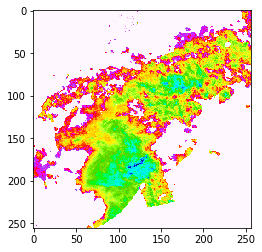

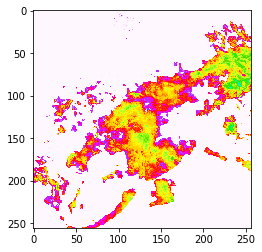

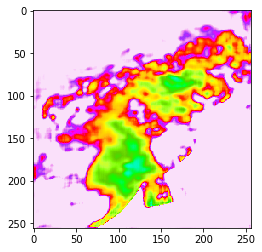

In [172]:
plt.imshow(x_last.reshape((image_size, image_size)), cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
plt.imshow(y_true_last.reshape((image_size, image_size)), cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()
plt.imshow(y_pred_last.reshape((image_size, image_size)), cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
plt.show()

# 用模型预测数据

In [ ]:
RAD_id_submit_list = os.listdir("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_test/")
print(len(RAD_id_submit_list))

In [ ]:
RAD_id = RAD_id_submit_list[11]

In [ ]:
x = np.empty((nt, image_size, image_size, 1))
y = np.empty((1, image_size, image_size, 1))
for i in range(nt):
    x[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_test/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 31 - nt)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / image_scalar
x = x.reshape((1, nt, image_size, image_size, 1))

for i in range(30):
    y = test_model.predict(x)
    y = np.where(y<0.03, -0.01, y)
    for j in range(nt - 1):
        x[0][j] = x[0][j + 1]
    x[0][-1] = y[0]
    if (31 + i) % 5 == 0:
        print('%2d:' % (31 + i))
        print(i // 5 + 1)
        plt.imshow(y[0].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
        plt.show()

In [ ]:
version = 'SRAD2018_submit_Neutrino_PredNet_v0.3.2.0_18.09.01.14.07'
start_time = time.time()
print(time.strftime("start time: %Y-%m-%d %H:%M:%S", time.localtime()))
for RAD_id_counter, RAD_id in enumerate(RAD_id_submit_list):
    x = np.empty((nt, image_size, image_size, 1))
    y = np.empty((1, image_size, image_size, 1))
    for i in range(nt):
        x[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_test/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 31 - nt)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / image_scalar
    x = x.reshape((1, nt, image_size, image_size, 1))
    if not os.path.exists("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s" % (version, RAD_id)):
        os.makedirs("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s" % (version, RAD_id))
    for i in range(30):
        y = test_model.predict(x)
        y = np.where(y<0.03, -0.01, y)
        for j in range(nt - 1):
            x[0][j] = x[0][j + 1]
        x[0][-1] = y[0]
        if (31 + i) % 5 == 0:
#             print('%2d:' % (31 + i))
#             print(i // 5 + 1)
            result = y[0].reshape((image_size, image_size)) * image_scalar
#             plt.imshow(result, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
#             plt.show()
            result = result.astype(np.uint8)
            result = np.where(result==0, 255, result)
            result = PIL.Image.fromarray(result)
            result = result.resize((501, 501))
#             plt.imshow(result, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
#             plt.show()
            result.save("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s/%s_f%03d.png" % (version, RAD_id, RAD_id, i // 5 + 1))
    if RAD_id_counter % 10 == 0:
        print('RAD_id_counter=%5d\t\tIt takes %.2f' % (RAD_id_counter, time.time() - start_time))
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))
print(time.strftime("end time: %Y-%m-%d %H:%M:%S", time.localtime()))

```bash
zip -r "SRAD2018_submit_Neutrino_PredNet_v0.3.2.0_18.09.01.14.07.zip" "SRAD2018_submit_Neutrino_PredNet_v0.3.2.0_18.09.01.14.07"
ls | wc -l
```
18.09.02 15.50

In [ ]:
version = 'SRAD2018_submit_Neutrino_PredNet_v0.3.1.0_18.09.01.13.38'
start_time = time.time()
print(time.strftime("start time: %Y-%m-%d %H:%M:%S", time.localtime()))
for RAD_id_counter, RAD_id in enumerate(RAD_id_submit_list[:1]):
    x = np.empty((nt, image_size, image_size, 1))
    y = np.empty((1, image_size, image_size, 1))
    for i in range(nt):
        x[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_test/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 31 - nt)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / image_scalar
    x = x.reshape((1, nt, image_size, image_size, 1))
    if not os.path.exists("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s" % (version, RAD_id)):
        os.makedirs("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s" % (version, RAD_id))
    for i in range(30):
#         print('before predict %.2f' % (time.time() - start_time))
        y = test_model.predict(x)  # takes 0.2s to predict
#         print('after predict %.2f' % (time.time() - start_time))
        y = np.where(y<0.03, -0.01, y)
        for j in range(nt - 1):
            x[0][j] = x[0][j + 1]
        x[0][-1] = y[0]
        if (31 + i) % 5 == 0:
#             print('%2d:' % (31 + i))
#             print(i // 5 + 1)
            result = y[0].reshape((image_size, image_size)) * image_scalar
#             plt.imshow(result, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
#             plt.show()
            result = result.astype(np.uint8)
            result = np.where(result==0, 255, result)
            result = PIL.Image.fromarray(result)
            result = result.resize((501, 501))
#             plt.imshow(result, cmap=cm.gist_ncar_r, vmin=vmin, vmax=vmax)
#             plt.show()
            result.save("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s/%s_f%03d.png" % (version, RAD_id, RAD_id, i // 5 + 1))
    if RAD_id_counter % 10 == 0:
        print('RAD_id_counter=%5d\t\tIt takes %.2f' % (RAD_id_counter, time.time() - start_time))
print(time.strftime('It took  %H:%M:%S', time.gmtime(time.time() - start_time)))
print(time.strftime("end time: %Y-%m-%d %H:%M:%S", time.localtime()))

In [ ]:
a = PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_test/%s/%s_%03d.png" % (RAD_id, RAD_id, 0)).resize((image_size, image_size))

In [ ]:
a = PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_submit/%s/%s/%s_f%03d.png" % (version, RAD_id, RAD_id, i // 5 + 1))

In [ ]:
np.array(a)